# Profiling execution times

In [1]:
import pprint
from time import sleep

from ufl.core.expr import Expr
from ufl import Form, inner, grad, dx, TestFunction, TrialFunction
from lucifex.mesh import rectangle_mesh
from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.solver import bvp_solver, projection_solver, interpolation_solver
from lucifex.utils import log_texec
from lucifex.viz import plot_bar


def poisson(
    u: Function,
    f: Function | Constant | Expr,
) -> tuple[Form, Form]:
    v = TestFunction(u.function_space)
    u_trial = TrialFunction(u.function_space)
    F_lhs = -inner(grad(v), grad(u_trial)) * dx
    F_rhs = -v * f * dx
    return F_lhs, F_rhs

def sleepy_multiply(a, b, t):
    sleep(t)
    return a * b

texec = {}
log_texec(sleep, texec, n=3)(0.123)
a_times_b = log_texec(sleepy_multiply, texec, n=3)(3, 4, 0.321)

print(f'a * b = {a_times_b}')
pprint.pp(texec)

a * b = 12
{'sleep': [0.12826722199679352, 0.1269514189916663, 0.12415263000002597],
 'sleepy_multiply': [0.32241151499329135,
                     0.32516633698833175,
                     0.32207836100133136]}


## Example: increasing mesh resolution

In [2]:
texec_poisson = {}

n_solve = 3
Nx = [int(2 ** i) for i in range(7)]
for nx in Nx:
    mesh = rectangle_mesh(1.0, 1.0, nx, nx)
    u = Function((mesh, 'P', 1))
    f = Constant(mesh, 1.0)
    u_solver = bvp_solver(poisson, overwrite=True)(u, f)
    key = f'poisson_Nx={nx}'
    log_texec(u_solver.solve, texec_poisson, key, n=n_solve)()

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$N_x$', ylabel='$t_{\\mathrm{exec}}$'>)

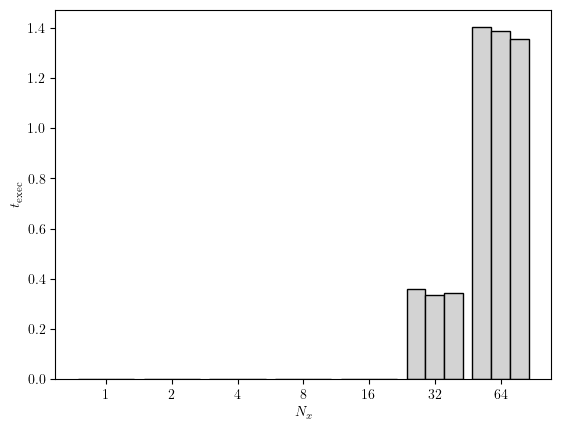

In [3]:
plot_bar((texec_poisson.values()), Nx, x_label='$N_x$', y_label='$t_{\mathrm{exec}}$')

## Example: caching assembled matrices

In [2]:
texec_caching = {}

n_solve = 3
nx = 100
mesh = rectangle_mesh(1.0, 1.0, nx, nx)
cache_matrix = (False, True)
for cm in cache_matrix:
    u = Function((mesh, 'P', 1))
    f = Constant(mesh, 1.0)
    u_solver = bvp_solver(poisson, overwrite=True, cache_matrix=cm)(u, f)
    key = f'poisson_Nx={nx}_cache={cm}'
    log_texec(u_solver.solve, texec_caching, key, n=n_solve)()
    print(
        f'cache_matrix={cm}', 
        f"assembly_count={u_solver.get_matrix().getAttr('assembly_count')}",
    )


cache_matrix=False assembly_count=3
cache_matrix=True assembly_count=1


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='$t_{\\mathrm{exec}}$'>)

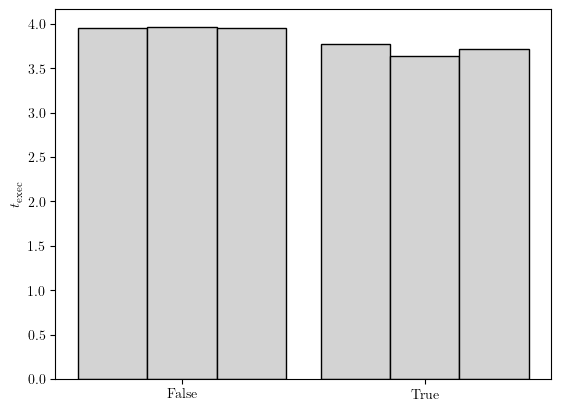

: 

In [ ]:
plot_bar((texec_caching.values()), cache_matrix, y_label='$t_{\mathrm{exec}}$')

## Example: projection versus interpolation

In [4]:
def exponentiate(a, b):
    return a ** b

texec_expn = {}

n_solve = 5
nx = 100
mesh = rectangle_mesh(1.0, 1.0, nx, nx)
a = Function((mesh, 'P', 1), lambda x: x[0] * x[1])
b = Function((mesh, 'P', 1), lambda x: x[0])

methods = ('projection', 'interpolation')
for mthd in methods:
    u = Function((mesh, 'P', 1))
    if mthd == 'projection':
        ab_solver = projection_solver(u, exponentiate, overwrite=True)(a, b)
    elif mthd == 'interpolation':
        ab_solver = interpolation_solver(u, exponentiate, overwrite=True)(a, b)
    else:
        raise ValueError
    log_texec(ab_solver.solve, texec_expn, mthd, n=n_solve)()
    
pprint.pp(texec_expn)

{'projection': [0.014735492994077504,
                0.0071695759979775175,
                0.00739038000756409,
                0.007949414997710846,
                0.007336782000493258],
 'interpolation': [0.0031785210012458265,
                   0.0030294320022221655,
                   0.002836772007867694,
                   0.002301611006259918,
                   0.002456510002957657]}


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='$t_{\\mathrm{exec}}$'>)

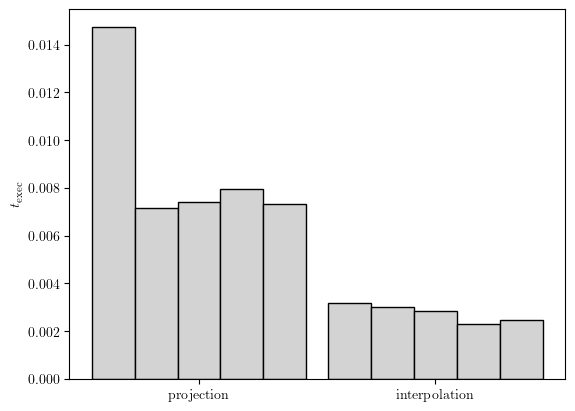

In [5]:
plot_bar((texec_expn.values()), methods, y_label='$t_{\mathrm{exec}}$')